# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

Text(0, 0.5, 'Excess Returns')

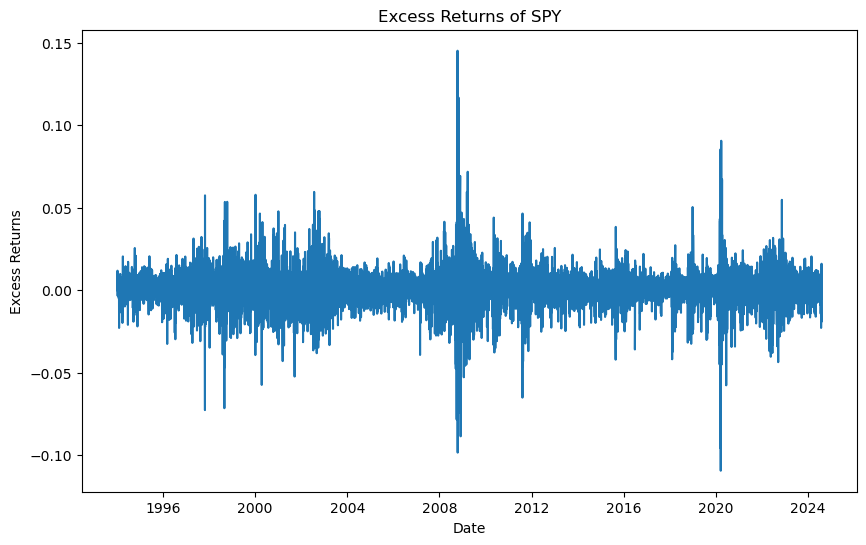

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

spy = pd.read_excel("spy_data.xlsx", sheet_name = "total returns")
spy['date'] = pd.to_datetime(spy['date'])
spy.set_index('date', inplace=True)
spy['ER'] = spy['SPY'] - spy['^IRX']

# Assuming 'spy' already has the datetime index set
plt.figure(figsize=(10, 6))
sns.lineplot(x=spy.index, y='ER', data=spy)
plt.title('Excess Returns of SPY')
plt.xlabel('Date')
plt.ylabel('Excess Returns')

***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

5% VaR backtest: 4.86%


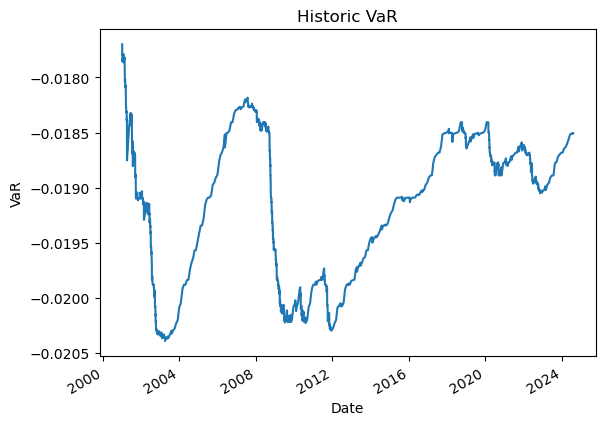

In [152]:
start_index = spy.index.get_loc('2001-01-02') # identify starting period
historic_VaR = spy['ER'].shift().expanding(min_periods = start_index).quantile(.05)
historic_VaR.plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')

exceed = sum(spy['ER'] < historic_VaR)/len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceed))

## **Drawbacks of Historic VaR**
    1. Considers market periods that might bear small resemblance to the current market environment. For example, using the data during COVID-19 might skew the results.
    2. All observations equally-weighted whereas we might want to give more weight to recent observations, as they might be more reflective of the current environment.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

## Report the items below, starting at , starting at `Jan 2, 2001`.

### 1. For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)


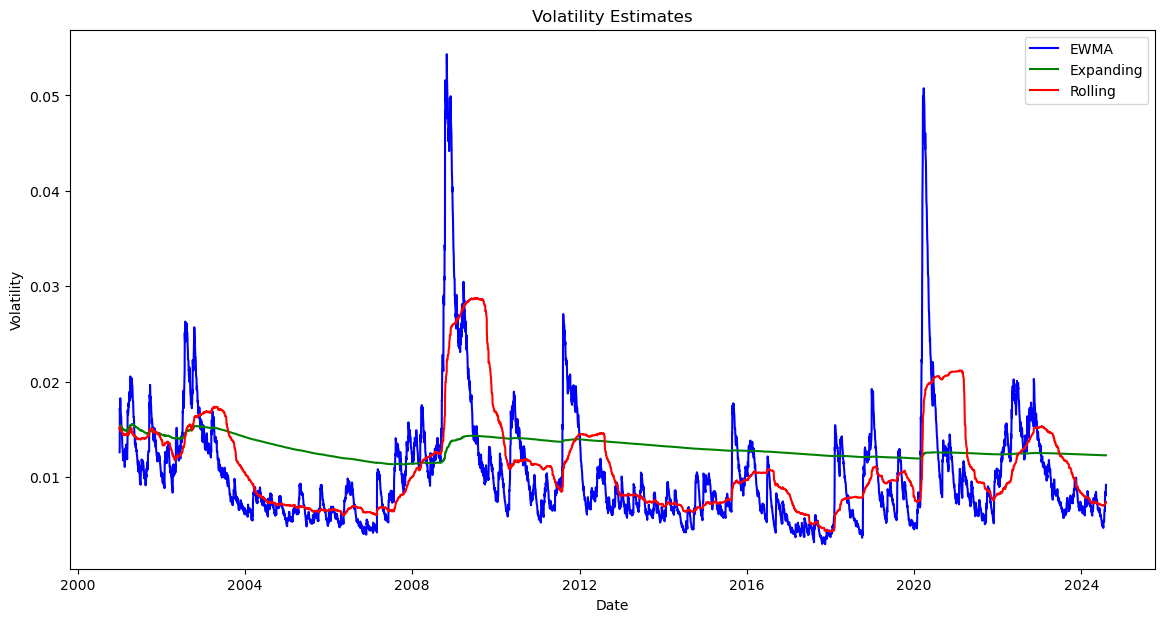

In [153]:
## Calculate expanding, rolling methods
rets = spy['ER'].iloc[(start_index - 252):] # starts both statistics at 1/2/2001
expanding_window = np.sqrt((rets**2).expanding(min_periods = 252).mean().shift())
rolling_window = np.sqrt((rets**2).rolling(window = 252).mean().shift())

## Calculate EWMA recursively
# Set-up
ewma_raw = pd.DataFrame({
    'rets' : rets.values,
    'ewma' : np.nan * len(rets.index)
}, index = rets.index)
ewma = ewma_raw[ewma_raw.index >= '2001-01-01']

# Calculation
theta = 0.94
ewma['ewma'].iloc[0] = 0.2/np.sqrt(252)
for i in range(1,len(ewma)):
    ewma['ewma'].iloc[i] = np.sqrt(theta * (ewma['ewma'].iloc[i-1]**2) + (1 - theta) * (ewma['rets'].iloc[i-1]**2))

## Compare methods
ewma.drop(columns = ['rets'], inplace = True)
ewma['expanding'] = expanding_window
ewma['rolling'] = rolling_window
plt.figure(figsize=(14, 7))
sns.lineplot(data=ewma['ewma'], label='EWMA', color='blue')
sns.lineplot(data=ewma['expanding'], label='Expanding', color='green')
sns.lineplot(data=ewma['rolling'], label='Rolling', color='red')
plt.title('Volatility Estimates')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


### 2. For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$


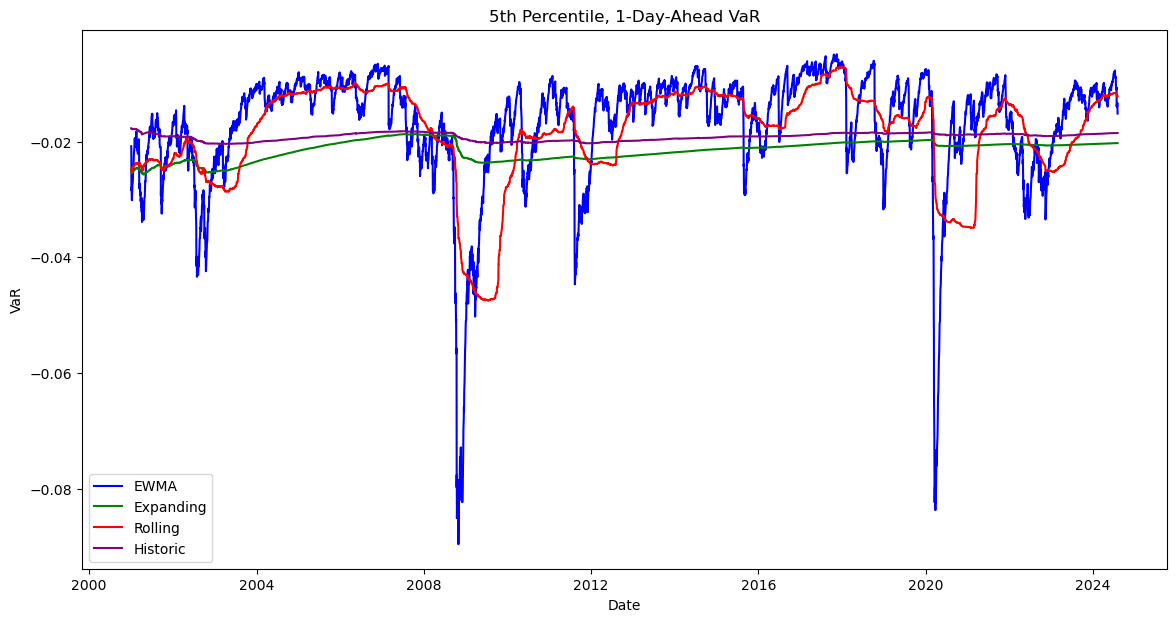

In [154]:
VaR = -1.65 * ewma
VaR['historic'] = historic_VaR

plt.figure(figsize=(14, 7))
sns.lineplot(data=VaR['ewma'], label='EWMA', color='blue')
sns.lineplot(data=VaR['expanding'], label='Expanding', color='green')
sns.lineplot(data=VaR['rolling'], label='Rolling', color='red')
sns.lineplot(data=VaR['historic'], label='Historic', color='purple')
plt.title('5th Percentile, 1-Day-Ahead VaR')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.show()


### 3. For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$



In [155]:
var_temp = VaR.dropna()
frequency =  var_temp.apply(lambda x: rets.loc[var_temp.index] < x).mean().to_frame('frequency')
display(frequency)

,frequency
ewma,0.059895
expanding,0.035431
rolling,0.052809
historic,0.048591


### 4. Compare and contrast your results among each other and relative to the historic method in the previous problem.

From the time series of VaR estimates, I would prefer either (1) an EWMA approach that assigns less weight to recent observations (to reduce volatility) or (2) a shorter (< a year) rolling window (to decrease the lag of the rolling window). As expected, the expanding and historic VaR measures are insensitive to new information and weight all observations the same, regardless of whent they occured.

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

<Axes: title={'center': 'CVaR estimates'}, xlabel='Date', ylabel='5% CVaR'>

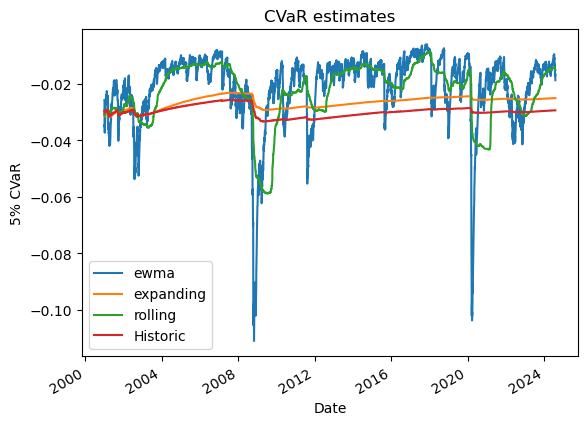

In [157]:
from scipy.stats import norm
CVaR = -norm.pdf(1.65) / 0.05 * ewma
CVaR['Historic'] = rets.expanding(60).apply(lambda x: x[x < x.quantile(.05)].mean())
CVaR.plot(title = 'CVaR estimates', ylabel = '5% CVaR', xlabel = 'Date')

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.